# <center>An Elementary Particle Collider Signal Filter</center>
#### <center> Developed by Luke Surber, SurberL9@uw.edu </center>

### README: 

### This notebook was originally aimed at modeling the luminosity and particle distributions of particles traveling in a collider, the aim now is to demonstrate the process of filtering out any noise from a signal using Python code and ML techniques. In High Energy Physics (HEP), very often the problem of seperating signal from backgroundnoise arises; some scenario include resonant peaks from particle decays (focus of this nb), physics object reconstruction/identification (id est pions, photons, electrons, b(t)-jets...), nuclear interactions with detector materials, photon conversions with detector material, all of these phenomena would be combined with noise. The example scenario used in this notebook is the Higgs boson decay, it's resonant peak occurs at ~125 GeV, we're assuming an STD of 20 GeV (Revisit this later...); this signal is 'dirtied' in two ways, first there's an additional background signal(s) (calling it background noise) that has a gaussian distribution (sigma=30GeV,mu=30GeV)(will add more peaks later to represent other particle resonances), and second there's an overall random noise that 'dirties' the signal further (mechanical, electrical,...). All of these sources of noise need to be filtered out, this is our goal.
##### NOTE: run a cell with "!pip install --upgrade jax jaxlib" for systems that haven't installed JAX yet.

### Overview: 
### Upon measuring and recording data for the Higgs Boson resonance, the process of filtering out the noise therein naturally arises. The dataset would have two kinds of values, the bin values which span an amount of energy (2.5 GeV in this nb's case), and the event counts that correspond to those specific bins.
### In the notation below the bin values are the $x_m$ values, and the event counts for the specific bin are the $y_m$ values. The parameters $\sigma$ and $\mu$, which represent the signal standard deviation (std) and median (peak) respectively, are the components of a arbitrary vector $\beta$, and there is a specific vector, $\beta_*$, that best fits the Higgs Boson signal.
### The first step in the data filtration would be to apply the Signal to Noise Ratio method, this method finds a value for energy that corresponds to a bin that, if the events in all bins of equal or lower energy are removed from the data, then the remaining data contains the most signal and the least noise (id est signals from lower energy particle resonances). After doing this the data will be primed for optimization, allowing for the best fit parameters to be found.
### The goal now is to apply the least-squares method to find those best fit parameters that most accurately fit the Higgs Boson signal, while supressing/ignoring the remnant counts from lower energy resonance peaks of other particles (reffered to as noise from here on), as well as overall random noise. 
### The vector $\beta_*$ can be solved for by finding the global minimum in the cost function, $\Omega(\sigma,\mu)$ , using the least-squares method. <center>$\Omega=\sum_{i=1}^{m}r_{i}^{2}$.</center> The residual $r_i$ is simply the difference between the event count in the bin and the gaussian function $f(x_i,\beta)$, <center>$r_i=y_i-f(x_i,\beta)$, where $f(x_i,\beta)=f(x,\beta_1=\sigma,\beta_2=\mu)=\dfrac{1}{\sigma\sqrt{2\pi}}e^{-\dfrac{(x_i-\mu)^2}{\sigma^2}}$.</center> Thus the cost function has the form, <center> $\Omega=\sum_{i=1}^{m}\left(y_i-\dfrac{e^{-\dfrac{(x_i-\mu)^2}{\sigma^2}}}{\sigma\sqrt{2\pi}}\right)^{2}$. </center>
### The shape of $\Omega$ as a function of $\beta$ should be (and is) concave, and the global minimum here would correspond to $\beta_*$, the best fit parameters in otherwords, these values ideally should converge to the signal parameters.

### The goal now is to implement the least-squares method on the cost function, $\Omega(\hat\beta)$, to get $\beta_*$.
### To accomplosh this, the gradient of the cost function can be set to ~zero, providing two linearly independent equations that can be solved for the components of $\beta_*$, $\sigma_*$ and $\mu_*$.
### <center> $\dfrac{\partial\Omega}{\partial\beta_j}=2\sum_{i}r_{i}\dfrac{\partial r_i}{\partial\beta_j}=0$,   where $j=[1,2],{\beta}_j=[\sigma,\mu]$ </center>
### <center> $\dfrac{\partial\Omega}{\partial\beta_1}=\dfrac{\partial\Omega}{\partial\sigma}=2\sum_{i}r_{i}\dfrac{-\left(2 \mu ^2-\sigma ^2+2 x^2-4 \mu  x\right)}{\sqrt{2 \pi } \sigma ^4}e^{-\dfrac{(x-\mu )^2}{\sigma ^2}}$,</center> <center>$\dfrac{\partial \Omega}{\partial \beta_2}=\dfrac{\partial \Omega}{\partial \mu}=2\sum_{i}r_{i}\dfrac{-2 (x-\mu )}{\sqrt{2 \pi }\sigma ^3}e^{-\dfrac{(x-\mu )^2}{\sigma ^2}}$. </center>

### A different approach to finding the best fit parameters for the signal would be to implement gradient descent on the cost function, $\Omega(\beta)$, to get $\beta_*$. This method isn't exactly neccesary since it's possible to solve for $\beta_*$ explicitly because the cost function will have just one global minimum; however if the toydata were replaced with a genuine dataset one might find several minimas which would mean the gradient descent method is actually required... 
### To perform gradient descent, an intial guess $\beta_{0}$ is needed, this would consist of a guess for the $\sigma$ and $\mu$ parameters of the model gaussian, a reasonable guess for $\mu$ would be the appararent maximum in the data set (the peak), and I'm currently unsure of the best way to choose an intiial $\sigma$.

### Applying Gradient Descent to this Linear System so we can obtain the approximate optimal parameters, $\sigma$, and $\mu$.
### Using our cost function, $\Omega(\beta)$. The algorithm to apply is as follows:
### <center>$\bf{\beta}_{n+1}=\bf{\beta}_n-\gamma\nabla \Omega(\bf{\beta}_n)$,</center>
### where $\bf{\beta}_{n=0}$ is our guess $\beta_{0}$, and $\gamma$ is the step size, $\gamma \in \mathbb {R} _{+}$; our choice of $\gamma$ should be small enough so that $\Omega(\bf{\beta}_n)\geq\Omega(\bf{\beta}_{n+1})$, the idea being the iterative algorithm should minimize the Cost function values until the approximate local minimum is found.
### The sequence of iterations are intended to "descend" the Omega data surface in descrete steps until the minimum (certainly the global minima in this specific case) is found, and the coordinates for this point will be denoted as $\beta_*$; to reiterate, the coordinates indicate the signal's best fit values. 

In [1]:
import jax.numpy as jnp
import random as rand
import math, jax
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
from jax import grad, jit, vmap, random
from numpy import inf
from numpy import linalg as LA
key = random.PRNGKey(0)
plt.style.use('dark_background')

In [2]:
#########################################################################################
#                            Signal to Noise Ratio                                      #
#########################################################################################
def SNR(s, n): #Defining the Continuous SNR Function.
    snr, Srray, Nrray = [], [], []
    for i in range(len(s[0])):
#Below; Mathematical equivalent to a 'running' Riemann Sum or Definite Integration.
        N = 2.5 * jnp.nansum(n[0][:i+1])
        S = s[0][i+1]
        Srray.append(S)
        Nrray.append(N)
        N = np.sum(Nrray)
        r = S / N**2
#Below; Appropriately interpolates the datset with zeroes.        
        r = jnp.nan_to_num(r, nan=0.0, posinf=0.0)
        snr.append(r.item())
    return snr, Srray, Nrray
#Notes: TypeError appears when using jnp.sum here, the jnp version requires ndarray or scalar arguments.
#########################################################################################
#                             Toy Data Generation                                       #
#########################################################################################
#  Example Scenario: Higgs Boson has a 125 GeV Mass, assuming an arbitrary 20 GeV STD.  #
sig_events, nos_events, Emax = 10**5, 5*10**4, 250
sig_mean, nos_mean, sig_std, nos_std = 125, 30, 20, 30 
size, mean, cov, bins = sig_events, jnp.array([sig_mean,nos_mean]).block_until_ready(), jnp.array([[sig_std**2,0],[0,nos_std**2]]).block_until_ready(), Emax 
#Generating Two Gaussian Distributions that are used for the background noise and signal.
signal, noise = random.multivariate_normal(key, mean, cov, (size,)).T.block_until_ready()
signal, noise = signal[signal<250], noise[noise<100] #Implementing the bounds on the data.
#Combining the signal with both background nosie and random noise.
data_array = jnp.concatenate((signal,noise[:nos_events]))+np.random.normal(0,2.5,len(signal)+len(noise[:nos_events])) 
sig = jnp.histogram(signal, bins=bins, range=(0,250), density=False)
sign = jnp.histogram(signal, bins=bins, range=(0,250), density=True)
nos = jnp.histogram(noise, bins=bins, range=(0,100), density=False)
snr_dat, s, n = SNR(sig, nos)[:125][0], SNR(sig, nos)[:125][1], SNR(sig, nos)[:125][2]
snr_domain = jnp.arange(0,125,0.5)
optimal_cut = 2.5*round((snr_domain[snr_dat.index(jnp.nanmax(jnp.asarray(snr_dat)).item())].item())/2.5)
#Rounding here is neccesary to get the nearest bin value
cut_data_array = data_array[data_array > optimal_cut]
data_hist = jnp.histogram(data_array, bins=bins, range=(0,250), density=False)
data_histn = jnp.histogram(data_array, bins=bins, range=(0,250), density=True)
cut_data_hist = jnp.histogram(cut_data_array, bins=bins, range=(0,250), density=False); 
cut_data_histn = jnp.histogram(cut_data_array, bins=bins, range=(0,250), density=True);
##########################################################################################
#                                Latest Version                                          #
##########################################################################################

### denote here what x,y,beta,b1,b2,X,Y,Omega,g1,g2,g,h,l,logg,ect all mean
### denote here the naming convention for the below functions and objects; id est functions have several capitals and objects only have one...

b1 = jnp.arange(10,50,1,dtype=float) #The first component of Beta corresponds to Signa (STD)
b2 = jnp.arange(75,175,2.5,dtype=float) #The second component of Beta corresponds to Mu (Avg.)
x, y = cut_data_hist[1][:-1], cut_data_hist[0] #THIS TESTS THE NOISE+sIGNAL DISTRIBUTION AFTER THE SNR CUT.
xb, yb = data_hist[1][:-1], data_hist[0] #THIS TESTS THE NOISE+sIGNAL DISTRIBUTION BEFORE THE SNR CUT.
xs, ys = sig[1][:-1],sig[0] #THIS TESTS JUST THE SIGNAL DISTRIBUTION, NO NOISE.
Y, Yb = jnp.asarray(y), jnp.asarray(yb) #Event Counts in a specific Bin
X, Xb = jnp.asarray(x), jnp.asarray(xb) #Bin Value

def Gauss(x,s,m): return (1.0/(s*jnp.sqrt(2.0*math.pi)))*jnp.exp(-(1/2)*((x-m)/s)**2) #Generic Gaussian Function Above for Examining a specific Beta
def Omega(x,y,s,m): #General Omega/Cost Function.
    r = y/np.sum(y) - Gauss(x,s,m)
    return jnp.sum((r**2))
def Omega2(s,m): #Bivariate Omega/Cost Function. #Not confident this is useful for testing...
    r = Y/np.sum(Y) - Gauss(X,s,m)
    return jnp.sum((r**2))
def OmegaData(X, Y, b1, b2): #Computes the Cost Function data
    o_array = []
    for i in range(len(b1)):
        o_row = []
        for j in range(len(b2)):
            o = Omega(X, Y, b1[i], b2[j]).item()
            o_row.append(o)
        o_array.append(o_row)
    return np.asarray(o_array)
Omegadata = OmegaData(X, Y, b1, b2)
Omegaminima = np.min(Omegadata)
Bestfit_ij = np.where(Omegadata==Omegaminima)
Bestfit = b1[Bestfit_ij[0][0]], b2[Bestfit_ij[1][0]]
#This portion is for the xb, yb datasets, in other words for the data before the SNR cut.\
Omegadatab = OmegaData(Xb, Yb, b1, b2)
Omegaminimab = np.min(Omegadatab)
Bestfit_ijb = np.where(Omegadatab==Omegaminimab)
Bestfitb = b1[Bestfit_ijb[0][0]], b2[Bestfit_ijb[1][0]]

Omegagradient = jit(grad(Omega, argnums=[2,3])) #JAX transformation Gradient of the above Cost function
def GradientData(X, Y, b1, b2): #Computes the two gradient components (two Beta components) of the Omega function.
    g1_array, g2_array, g_array = [], [], []
    for i in range(len(b1)):
        g1_row, g2_row, g_row = [], [], []
        for j in range(len(b2)): 
            g1, g2 = Omegagradient(X, Y, b1[i], b2[j])[0].tolist(), Omegagradient(X, Y, b1[i], b2[j])[1].tolist()
            g1_row.append(g1) #g1 is the cost function derivative with respect to b1, which is Sigma (STD).
            g2_row.append(g2) #g2 is the cost function derivative with respect to b2, which is Mu (Peak).
            g_row.append(LA.norm(np.array([g1,g2]))) #g is the magnitude of gradient of the cost function.
        g1_array.append(g1_row)
        g2_array.append(g2_row)
        g_array.append(g_row)
    return np.asarray(g1_array), np.asarray(g2_array), np.asarray(g_array) #jnp.asarray doesn't work the same as np.asarray, difference being the output type is Device Array and for the other it's Array.
g1data, g2data, Gradientdata = GradientData(X, Y, b1, b2)
g1datab, g2datab, Gradientdatab = GradientData(Xb, Yb, b1, b2)
LogGradientdata = jnp.log(Gradientdata)
LogGradientdata = jnp.nan_to_num(LogGradientdata, nan=0, posinf=0, neginf=0)

def Gradient_Vector(X, Y, b1, b2): return np.asarray([Omegagradient(X, Y, b1, b2)[0].tolist(), Omegagradient(X, Y, b1, b2)[1].tolist()])

def Gradient_Descent(X, Y, s, m, step_size, iterations):
    """
    X : The dataset full of the bin Energy values
    Y : The dataset full of the amplitudes corresponding to the specific bins
    s : The intial guess for the STD of the function representing the dataset
    m : The intial guess for the median value of the function representing the dataset
        The step_size is trivial, but note in this nb it's large.
    """
    beta, beta_history, cost_history = np.asarray([s, m]), [], []
    for i in range(iterations):
        cost = Omega(X, Y, beta[0], beta[1])
        beta_history.append(beta)
        cost_history.append(cost)
        nabla = Gradient_Vector(X,Y,beta[0],beta[1])
        beta = beta - step_size * nabla
        warning = "Iteration {}: The algorithm has encountered an out of range error... ending algorthim now. {} < {}."
        #Exceptions for when the algorithim considers parameters outside of the predetermined bounds.
        if beta[0] < jnp.min(b1).item(): 
            print(warning.format(i, beta[0], jnp.min(b1).item())) 
            break
        if beta[0] > jnp.max(b1).item():
            print(warning.format(i, beta[0], jnp.max(b1).item())) 
            break
        if beta[1] < jnp.min(b2).item():
            print(warning.format(i, beta[1], jnp.min(b2).item())) 
            break
        if beta[1] > jnp.max(b2).item():
            print(warning.format(i, beta[1], jnp.max(b2).item())) 
            break        
    return beta, beta_history, cost_history[:-1]
print("Everything works.")

Everything works.


In [3]:
#Insert plots of the data by itself, the SNR data, the SNR cut data
#along with the a comparison of the cost function minimas for both
#dirty data and SNR cut data, illustrate the signal+noise components

The global minimum in the Cost Data corresponds to the following best values, (σ,μ)=(23.0,122.5GeV).
The Gradient Descent algorithim found the best fit values (σ,μ)=(22.4,123.5GeV).


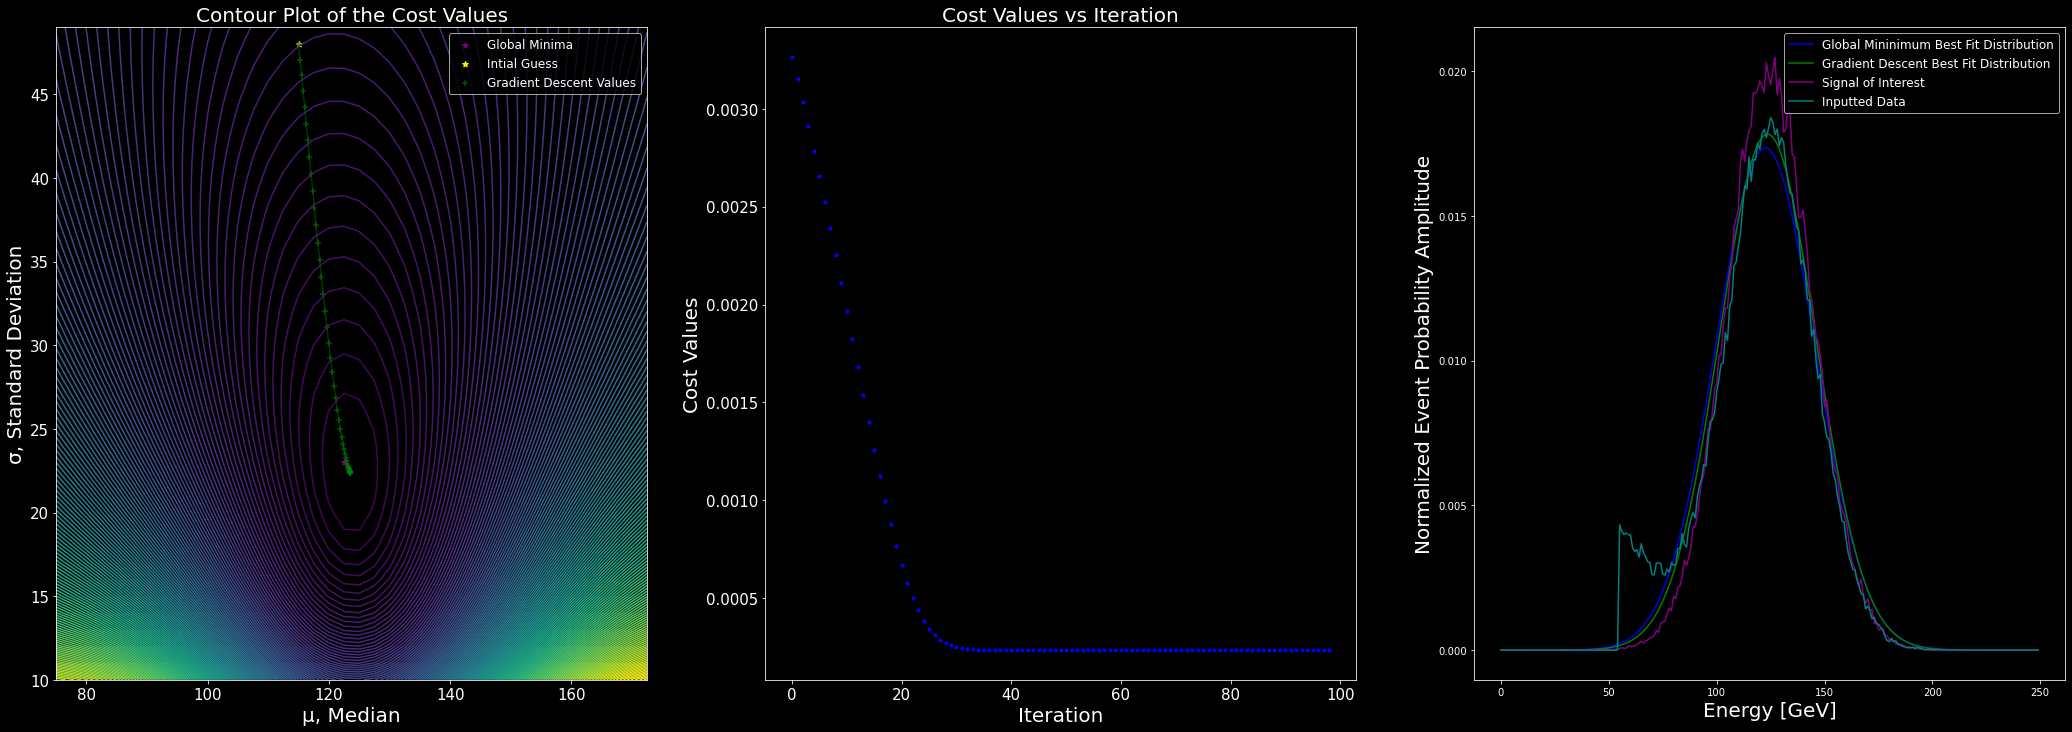

In [4]:
#Gradient Descent
guess_beta, step_size, iterations = [48.0, 115.0], 8000, 100 #Step sizes have to be considerably large here.
final_beta, beta_history, cost_history = Gradient_Descent(X,Y,guess_beta[0],guess_beta[1],step_size,iterations)
beta_x = []
beta_y = []
for beta in beta_history:
    beta_x.append(list(beta)[1])
    beta_y.append(list(beta)[0])

fig, axs = plt.subplots(1,3, figsize=(36,12))
axs[0].set_title("Contour Plot of the Cost Values", size=20)
axs[0].set_ylabel("σ, Standard Deviation", size=20)
axs[0].set_xlabel("μ, Median", size=20)
axs[0].tick_params(labelsize=15)
axs[0].contour(b2, b1, Omegadata, 150, cmap="viridis")
axs[0].scatter(Bestfit[1],Bestfit[0], color="purple", marker="*", label="Global Minima")
axs[0].scatter(guess_beta[1], guess_beta[0], color="yellow", marker="*", label="Intial Guess")
axs[0].scatter(beta_x,beta_y, color="green", alpha=0.6, marker="+", label="Gradient Descent Values")
axs[0].plot(beta_x,beta_y, color="green", alpha=0.4)
axs[0].legend(prop={'size':12}, loc='upper right')

axs[1].set_ylabel('Cost Values', size=20)
#axs[1].set_yscale("log")
axs[1].set_xlabel('Iteration', size=20)
axs[1].set_title("Cost Values vs Iteration", size=20)
axs[1].tick_params(labelsize=15)
axs[1].plot(range(len(cost_history)),cost_history,'b.')

axs[2].set_xlabel("Energy [GeV]", size=20)
axs[2].set_ylabel("Normalized Event Probability Amplitude", size=20) #Normalized meaning the sum of probabilties is unity.
axs[2].plot(cut_data_hist[1][:-1], Gauss(cut_data_hist[1][:-1],Bestfit[0],Bestfit[1]), color="blue", alpha=0.9, label="Global Mininimum Best Fit Distribution")
axs[2].plot(cut_data_hist[1][:-1], Gauss(cut_data_hist[1][:-1],final_beta[0],final_beta[1]), color="green", label="Gradient Descent Best Fit Distribution")
axs[2].plot(sign[1][:-1], sign[0], color="purple", label="Signal of Interest")
axs[2].plot(x, y/np.sum(y), color="teal", label='Inputted Data')

axs[2].legend(prop={'size':12},loc='upper right')

print("The global minimum in the Cost Data corresponds to the following best values, (σ,μ)=({},{}GeV).".format(Bestfit[0],Bestfit[1]))  
print("The Gradient Descent algorithim found the best fit values (σ,μ)=({},{}GeV).".format(round(final_beta[0],1),round(final_beta[1],1)));

In [5]:
### Shape of Omegadata is now as expected after fixing the Omega function
### Gradient Descent works, the step size was far too small to work in this context
### Am ready to include several small peaks to create a more realistic dataset
### NOTES: The Curve Fitting via Cost Function Optimization works best if SNR cut is NOT done, which is interesting.
#behavior of JAX when differentiating a function that's discontinuous when looking at it's first derivative
#integrate the SNR optimization in the cost function optimization portion in order to expedite the overall process

In [6]:
print("The Higgs Boson signal began as a gaussian distribution with the parameters (σ,μ)=({},{} GeV).".format(sig_std,sig_mean))
print("If we apply the cost function optimization to the dataset before we perform the SNR cut we find that the optimal parameters (the coordinates in parameter space the correspond to a global minimum) are (σ,μ)=({},{} GeV). ".format(Bestfitb[0],Bestfitb[1]))
print("If we use gradient descent to estimate the optimal parameters, we would find the approximate optimal parameters to be (σ,μ)=({},{} GeV), which should be reasonably close, however this isn't exactly neccesary nor is this the optimal approach.".format(round(final_beta[0],1),round(final_beta[1],1)))
print("If we apply the cost function optimization to the dataset after we peform the SNR cut we find the optimal parameters to be (σ,μ)=({},{} GeV), this is a considerably improvement and means the SNR step is neccesary.".format(Bestfit[0],Bestfit[1]))

The Higgs Boson signal began as a gaussian distribution with the parameters (σ,μ)=(20,125 GeV).
If we apply the cost function optimization to the dataset before we perform the SNR cut we find that the optimal parameters (the coordinates in parameter space the correspond to a global minimum) are (σ,μ)=(30.0,122.5 GeV). 
If we use gradient descent to estimate the optimal parameters, we would find the approximate optimal parameters to be (σ,μ)=(22.4,123.5 GeV), which should be reasonably close, however this isn't exactly neccesary nor is this the optimal approach.
If we apply the cost function optimization to the dataset after we peform the SNR cut we find the optimal parameters to be (σ,μ)=(23.0,122.5 GeV), this is a considerably improvement and means the SNR step is neccesary.


In [7]:
beta_history

[array([ 48., 115.]),
 array([ 47.0807852 , 115.24295079]),
 array([ 46.14642337, 115.48971562]),
 array([ 45.19719635, 115.74036779]),
 array([ 44.23353407, 115.99497994]),
 array([ 43.25604292, 116.253621  ]),
 array([ 42.26554039, 116.51635466]),
 array([ 41.26309387, 116.7832349 ]),
 array([ 40.25006532, 117.05430041]),
 array([ 39.22816173, 117.32956563]),
 array([ 38.1994901 , 117.60901025]),
 array([ 37.16661704, 117.89256453]),
 array([ 36.13262861, 118.1800884 ]),
 array([ 35.10118863, 118.47134647]),
 array([ 34.07658816, 118.7659782 ]),
 array([ 33.06377952, 119.06345662]),
 array([ 32.06838358, 119.36304738]),
 array([ 31.0966586 , 119.66376189]),
 array([ 30.1554143 , 119.96431305]),
 array([ 29.25185771, 120.26308418]),
 array([ 28.39335373, 120.55811248]),
 array([ 27.58709678, 120.84711517]),
 array([ 26.83969732, 121.12755564]),
 array([ 26.15671004, 121.39676275]),
 array([ 25.54215996, 121.65209939]),
 array([ 24.998139  , 121.89115567]),
 array([ 24.52456691, 122.11